<a href="https://colab.research.google.com/github/lethanhnam1203/Machine-Deep-Learning-/blob/main/Variational_Autoencoder_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.datasets import mnist
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Dropout, InputLayer, Reshape
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.utils import np_utils
from keras.datasets import mnist
from keras.regularizers import l2
from keras.losses import binary_crossentropy
import tensorflow as tf
from keras import metrics, Input
import pandas as pd
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

## Task a: Implement and train a variational autoencoder on the MNIST dataset:

In [2]:
latent_dim = 20

In [3]:
def sample(z_mean, z_log_var):
    """
    nput:
      z_mean -- tensor
      z_logvar -- tensor
    Output
      z -- tensor, sampled based on the Gaussian distribution centered at z_mean with std = tf.exp(z_logvar * 0.5)
    """
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
    return z

In [4]:
def create_mnist_encoder(latent_dim):
    """
    Creata an encoder in VAE for minist data set
    Input:
        latend_dim -- integer
    Output
        encoder -- keras model
    """ 
    encoder = Sequential()
    encoder.add(InputLayer(input_shape=(28, 28, 1)))
    encoder.add(Conv2D(filters=32, kernel_size=3, strides=2, activation='relu', padding='same'))
    encoder.add(Conv2D(filters=64, kernel_size=3, strides=2, activation='relu', padding='same'))
    encoder.add(Flatten())
    encoder.add(Dense(400, activation='relu'))
    encoder.add(Dense(latent_dim+latent_dim, activation='relu'))
    return encoder

In [6]:
def create_mnist_decoder(latent_dim):
    """
    Creata a decoder in VAE for minist data set
    Input:
        latend_dim -- integer
    Output
        decoder -- keras model
    """
    decoder = Sequential()
    decoder.add(InputLayer(input_shape=(latent_dim, )))
    decoder.add(Dense(400, activation='relu'))
    decoder.add(Dense(7*7*64, activation='relu'))
    decoder.add(Reshape(target_shape=(7, 7, 64)))
    decoder.add(Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu', padding='same'))
    decoder.add(Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu', padding='same'))
    decoder.add(Conv2DTranspose(filters=1, kernel_size=3, strides=1, activation='sigmoid', padding='same'))
    return decoder

In [8]:
class VAE(keras.Model):
    """
    Variational Auto Encoder
    """
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = create_mnist_encoder(latent_dim)
        self.decoder = create_mnist_decoder(latent_dim)
        self.elbo_tracker = keras.metrics.Mean(name="ELBO")

    def compute_elbo(self, data):
        """
        Input:
          data --  tensor
        Output
          elbo -- float
        """
        x = self.encoder(data)
        z_mean, z_log_var = tf.split(x, num_or_size_splits=2, axis=1)
        z = sample(z_mean, z_log_var)
        reconstructed_data = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstructed_data), axis=(1, 2)))
        kl_divergence_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_divergence_loss = tf.reduce_mean(tf.reduce_sum(kl_divergence_loss, axis=1))
        elbo = reconstruction_loss + kl_divergence_loss
        return elbo

    def train_step(self, data):
        """

        """
        with tf.GradientTape() as tape:
            elbo = self.compute_elbo(data)
        grads = tape.gradient(elbo, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.elbo_tracker.update_state(elbo)
        return {"ELBO": self.elbo_tracker.result()}

In [9]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

latent_dim = 20
vae = VAE(latent_dim)
vae.compile(optimizer=keras.optimizers.Adam())

elbo_history = vae.fit(x_train, epochs=20, batch_size=128)

11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/20
469/469 [==============================] - 28s 7ms/step - ELBO: 195.7781
Epoch 2/20
469/469 [==============================] - 3s 6ms/step - ELBO: 164.4492
Epoch 3/20
469/469 [==============================] - 3s 6ms/step - ELBO: 161.1431
Epoch 4/20
469/469 [==============================] - 3s 6ms/step - ELBO: 159.3526
Epoch 5/20
469/469 [==============================] - 3s 6ms/step - ELBO: 157.7638
Epoch 6/20
469/469 [==============================] - 3s 6ms/step - ELBO: 156.1512
Epoch 7/20
469/469 [==============================] - 3s 6ms/step - ELBO: 155.2173
Epoch 8/20
469/469 [==============================] - 3s 6ms/step - ELBO: 154.7084
Epoch 9/20
469/469 [==============================] - 3s 6ms/step - ELBO: 154.1289
Epoch 10/20
469/469 [==============================] - 3s 6ms/step - ELBO: 153.7135
Epoch 11/20
469/469 [==============================] - 3s 6ms/step - ELBO: 153.5726
Epoch 12/20
469/469

## Task d: Plot the value of the ELBO during training

In [14]:
def visualise_elbo(elbo_history):
  """
  Visualise elbo during training
  Input:
    elbo_history -- keras.callbacks.History
  """
  elbo_records = elbo_history.history['ELBO']
  epoch_records = range(1, len(elbo_records)+1)
  plt.scatter(epoch_records, elbo_records, color='r')
  plt.plot(epoch_records, elbo_records)
  plt.xlabel('Epoch')
  plt.ylabel('ELBO')
  plt.title('ELBO during training')
  plt.show()

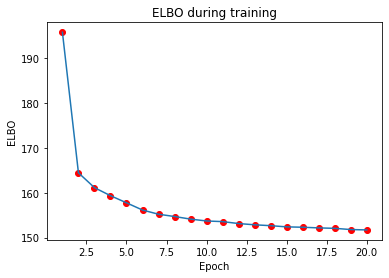

In [15]:
visualise_elbo(elbo_history)

## Task b: Visualize the reconstructions learned by the network for some test data.

In [12]:
def visualise_reconstructions(vae, x_test, number_of_samples):
  """
  Visualise some reconstructions learned by the VAE on test data
  Input:
    vae -- VAE modeel
    x_test -- np array
    number_of_samples -- integer
  """
  samples = np.random.randint(0, len(x_test), number_of_samples)
  for sample in samples:
    image = x_test[sample]
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image[:,:,0], cmap='gray')
    ax1.set_title("Original Image")
    image = image.reshape(-1, 28, 28, 1)
    x = vae.encoder(image)
    z_mean, z_log_var = tf.split(x, num_or_size_splits=2, axis=1)
    z = z_mean + tf.exp(0.5 * z_log_var) * tf.random.normal(shape=tf.shape(z_mean))
    new_image = vae.decoder(z)
    ax2.imshow(new_image[0,:,:,0], cmap='gray')
    ax2.set_title("Reconstructed Image")
    plt.show()

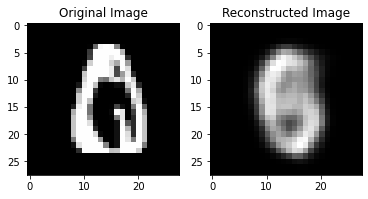

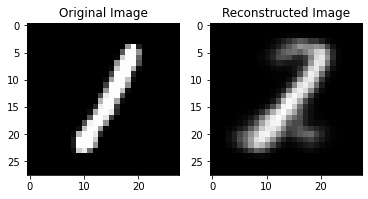

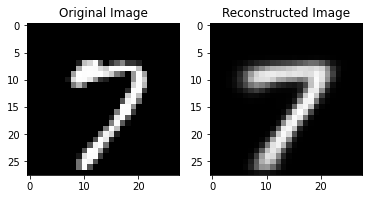

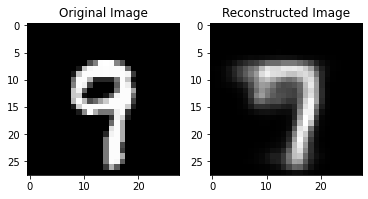

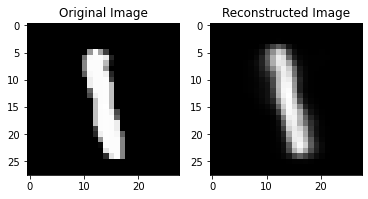

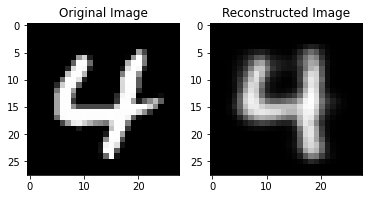

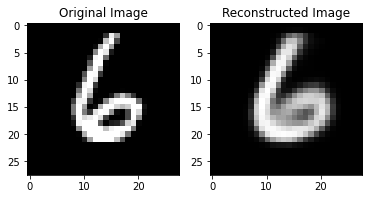

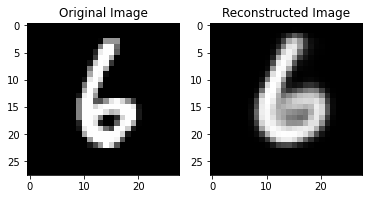

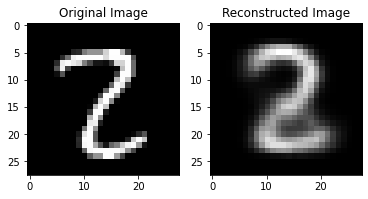

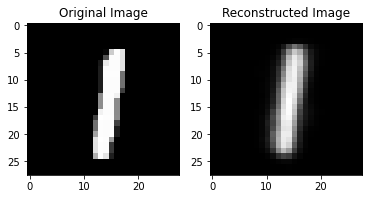

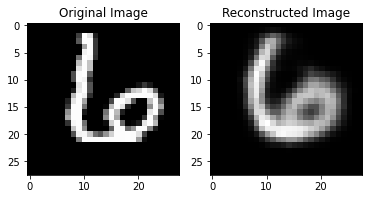

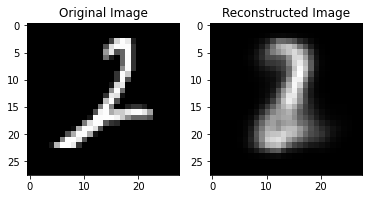

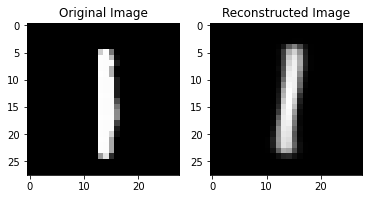

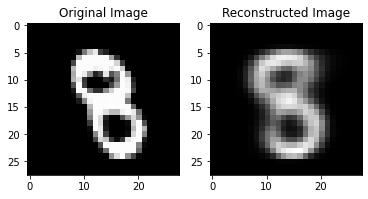

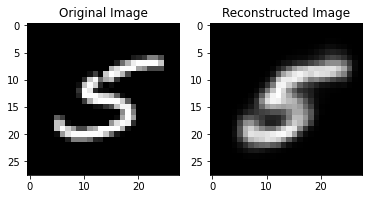

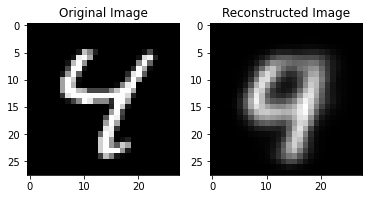

In [16]:
visualise_reconstructions(vae, x_test, number_of_samples=16)

## Task c: For  the  test  data  sample  from  the  latent  space  and  create  a  scatter  plot  of  thosesamples

In [25]:
def cluster_latents(vae, x_test, y_test, k=3):
  """
  Visualise some reconstructions learned by the VAE on test data
  Input:
    vae -- VAE modeel
    x_test -- np array
    y_test -- np array
    k -- integerr, number of PCA components, default = 3
  Output:
    x -- np array, shape = (len(x_test), k)
  """
  assert len(x_test) == len(y_test)
  result = np.empty(shape = (len(x_test),vae.latent_dim))
  for sample in range(len(x_test)):
    image = x_test[sample]
    image = image.reshape(-1, 28, 28, 1)
    x = vae.encoder(image)
    z_mean, z_log_var = tf.split(x, num_or_size_splits=2, axis=1)
    z = z_mean + tf.exp(0.5 * z_log_var) * tf.random.normal(shape=tf.shape(z_mean))
    z = z.numpy().flatten()
    result[sample,:] = z
  principal=PCA(n_components=k)
  principal.fit(result)
  x=principal.transform(result) 
  assert np.shape(x) == (len(x_test), k)
  return x

In [37]:
x = cluster_latents(vae, x_test, y_test)

Text(0.5, 0, 'PC3')

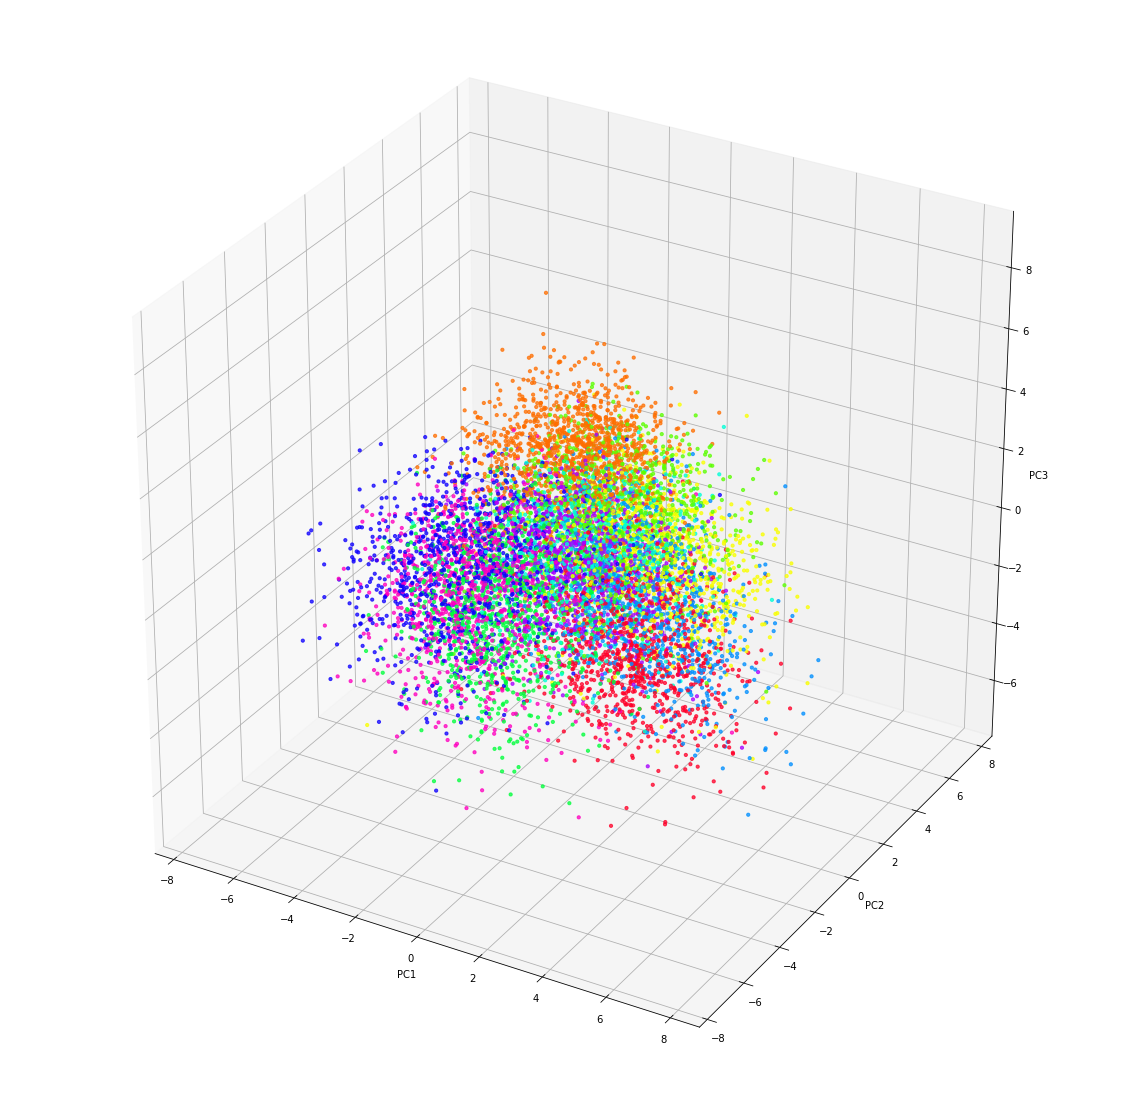

In [28]:
fig = plt.figure(figsize=(20,20))
  
# choose projection 3d for creating a 3d graph
axis = fig.add_subplot(111, projection='3d')
  
# x[:,0]is pc1,x[:,1] is pc2 while x[:,2] is pc3
axis.scatter(x[:,0],x[:,1],x[:,2], c=y_test, cmap='gist_rainbow',alpha=0.75, s=10)
axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)
axis.set_zlabel("PC3", fontsize=10)

I can say that there exist some clusters in this 3D space, though not that strong.